<a href="https://colab.research.google.com/github/sachin886x/deep-learning-lab/blob/main/mnsit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.datasets import mnist


In [ ]:
# Load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize + flatten (28x28 -> 784)
X_train = X_train.reshape(-1, 784).astype(np.float32) / 255.0
X_test  = X_test.reshape(-1, 784).astype(np.float32) / 255.0


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# One-hot encode labels
def one_hot(y, num_classes=10):
    out = np.zeros((y.shape[0], num_classes))
    out[np.arange(y.shape[0]), y] = 1
    return out

y_train_oh = one_hot(y_train, 10)
y_test_oh  = one_hot(y_test, 10)

print("Train:", X_train.shape, y_train_oh.shape)
print("Test :", X_test.shape, y_test_oh.shape)


Train: (60000, 784) (60000, 10)
Test : (10000, 784) (10000, 10)


In [ ]:
# ===============================
# Activation Functions
# ===============================
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return (Z > 0).astype(np.float32)

def softmax(Z):
    Z_shift = Z - np.max(Z, axis=1, keepdims=True)
    expZ = np.exp(Z_shift)
    return expZ / np.sum(expZ, axis=1, keepdims=True)

def cross_entropy(y_true, y_pred):
    eps = 1e-12
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))



In [ ]:
# ===============================
# Neural Network (2-layer MLP)
# ===============================
class NeuralNet:
    def __init__(self, input_size=784, hidden_size=128, output_size=10):
        # Xavier/He Init
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros((1, output_size))

    def forward(self, X):
        self.Z1 = X @ self.W1 + self.b1
        self.A1 = relu(self.Z1)
        self.Z2 = self.A1 @ self.W2 + self.b2
        self.A2 = softmax(self.Z2)
        return self.A2

    def backward(self, X, y_true, y_pred):
        m = X.shape[0]

        # Softmax + CrossEntropy gradient
        dZ2 = (y_pred - y_true) / m
        dW2 = self.A1.T @ dZ2
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * relu_derivative(self.Z1)
        dW1 = X.T @ dZ1
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        return dW1, db1, dW2, db2

    def update(self, grads, lr=0.01):
        dW1, db1, dW2, db2 = grads
        self.W1 -= lr * dW1
        self.b1 -= lr * db1
        self.W2 -= lr * dW2
        self.b2 -= lr * db2

    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)


In [ ]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

net = NeuralNet(input_size=784, hidden_size=128, output_size=10)

epochs = 10
lr = 0.01
batch_size = 128

losses = []
accs = []

for epoch in range(1, epochs + 1):
    # Shuffle training data
    idx = np.random.permutation(X_train.shape[0])
    X_train_shuff = X_train[idx]
    y_train_shuff = y_train_oh[idx]

    # Mini-batch training
    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train_shuff[i:i+batch_size]
        y_batch = y_train_shuff[i:i+batch_size]

        y_pred = net.forward(X_batch)
        grads = net.backward(X_batch, y_batch, y_pred)
        net.update(grads, lr=lr)

    # Evaluate after each epoch
    train_probs = net.forward(X_train[:5000])
    train_loss = cross_entropy(y_train_oh[:5000], train_probs)

    test_pred = net.predict(X_test)
    test_acc = accuracy(y_test, test_pred)

    losses.append(train_loss)
    accs.append(test_acc)

    print(f"Epoch {epoch}/{epochs} | Loss: {train_loss:.4f} | Test Acc: {test_acc*100:.2f}%")


Epoch 1/10 | Loss: 0.6468 | Test Acc: 85.10%
Epoch 2/10 | Loss: 0.4557 | Test Acc: 88.29%
Epoch 3/10 | Loss: 0.3862 | Test Acc: 89.69%
Epoch 4/10 | Loss: 0.3485 | Test Acc: 90.62%
Epoch 5/10 | Loss: 0.3236 | Test Acc: 91.05%
Epoch 6/10 | Loss: 0.3056 | Test Acc: 91.38%
Epoch 7/10 | Loss: 0.2907 | Test Acc: 91.85%
Epoch 8/10 | Loss: 0.2790 | Test Acc: 92.09%
Epoch 9/10 | Loss: 0.2688 | Test Acc: 92.45%
Epoch 10/10 | Loss: 0.2595 | Test Acc: 92.69%


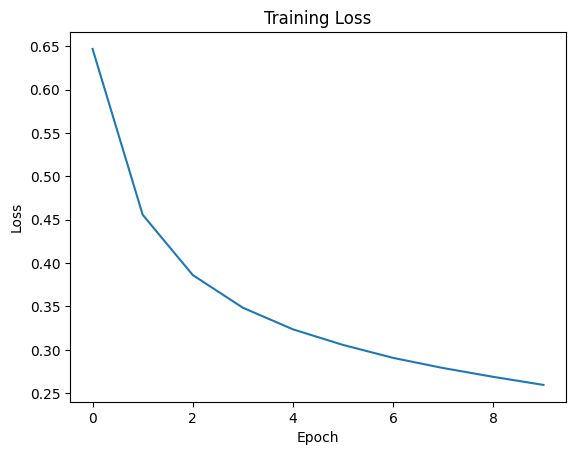

In [ ]:
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

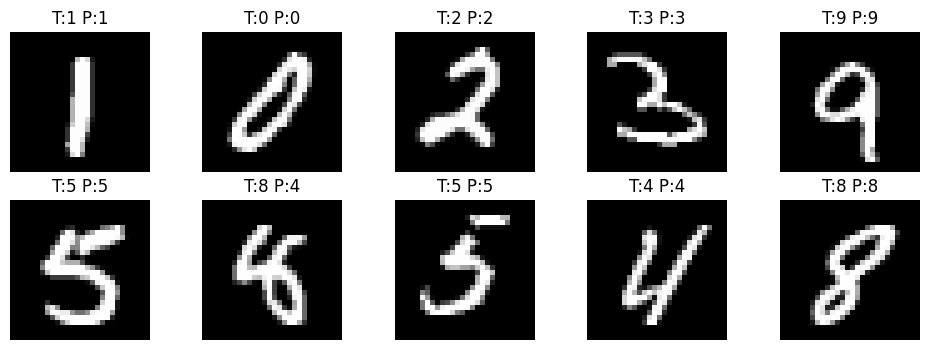

In [ ]:
n = 10
sample_idx = np.random.choice(len(X_test), n, replace=False)
samples = X_test[sample_idx]
true_labels = y_test[sample_idx]
pred_labels = net.predict(samples)

plt.figure(figsize=(12,4))
for i in range(n):
    plt.subplot(2,5,i+1)
    plt.imshow(samples[i].reshape(28,28), cmap="gray")
    plt.title(f"T:{true_labels[i]} P:{pred_labels[i]}")
    plt.axis("off")
plt.show()